In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional module for activation functions and more
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class BasicBlock(nn.Module):
    expansion = 1  # Expansion factor to adjust the number of output channels if needed

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer of the block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch normalization after the first convolution

        # Second convolutional layer of the block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch normalization after the second convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

        # Third convolutional layer of the block
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)  # Batch normalization after the third convolution

        # Fourth convolutional layer of the block
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)  # Batch normalization after the fourth convolution

        # Shortcut connection to match input and output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
      # Forward pass through the first convolution, batch norm, and ReLU activation
      out = F.relu(self.bn1(self.conv1(x)))
      # Forward pass through the second convolution and batch norm
      out = self.bn2(self.conv2(out))
      # Adding the shortcut connection's output to the main path's output
      out += self.shortcut(x)
      # Final ReLU activation after adding the shortcut
      out = F.relu(out)
      return out

In [3]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64  # Initial number of input channels

        # Initial convolutional layer before entering the residual blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the initial convolution

        # Creating layers of blocks with increasing channel sizes
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Final fully connected layer for classification
        self.linear1 = nn.Linear(512 * block.expansion, 256 * block.expansion)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256 * block.expansion, 128 * block.expansion)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Helper function to create a layer with specified blocks
        strides = [stride] + [1]*(num_blocks-1)  # First block could have a stride and the rest have stride of 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion  # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the initial convolution, batch norm, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Forward pass through all the layers of blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Global average pooling before the final layer
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.linear1(out)  # Final classification layer
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)

        return out

In [4]:
# Example of using the ResNet11 model
model = ResNet18(BasicBlock, [1, 1, 1, 1], num_classes=10)  # 4 blocks with 1 layer each
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [5]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 13030079.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

Using device: cuda:0


In [8]:
# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

Epoch 1, Training loss: 1.4291935688550854, Validation loss: 0.9719902888273659, Validation Accuracy: 64.3%
Epoch 2, Training loss: 0.9709185779628583, Validation loss: 0.8724973297918948, Validation Accuracy: 69.73%
Epoch 3, Training loss: 0.7357306598720837, Validation loss: 0.6587317185089611, Validation Accuracy: 77.44%
Epoch 4, Training loss: 0.5820786023723415, Validation loss: 0.6159451029742488, Validation Accuracy: 79.64%
Epoch 5, Training loss: 0.4594591370451855, Validation loss: 0.5806191346515863, Validation Accuracy: 80.8%
Epoch 6, Training loss: 0.35540305322568844, Validation loss: 0.5776261193588519, Validation Accuracy: 81.96%
Epoch 7, Training loss: 0.26560368056165357, Validation loss: 0.6076415341359358, Validation Accuracy: 82.06%
Epoch 8, Training loss: 0.1994724583899053, Validation loss: 0.613292212731922, Validation Accuracy: 82.9%
Epoch 9, Training loss: 0.1594004733759078, Validation loss: 0.6795514748214533, Validation Accuracy: 81.87%
Epoch 10, Training lo

Final Validation Accuracy: 83.55%
Total number of parameters in the model: 11334346


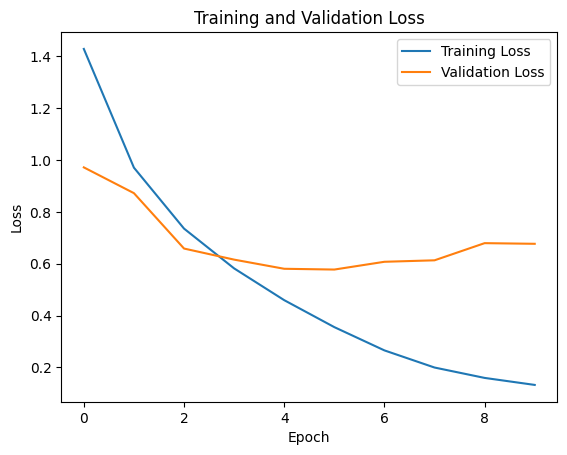

In [9]:
# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/ResNet_training_validation_loss.png')
plt.show()